In [4]:
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import pytensor.tensor as pt

In [5]:
def ar1_cov(t_0, t_1, rho=.5, sigma=1):
    """
    Compute the covariance of an AR1 process.
    """
    return sigma**2/(1 - rho**2) * np.exp(np.abs(t_1 - t_0) * np.log(rho))

cov_mat = np.array(
    [[ar1_cov(i, j, rho=.8) for i in range(156)] for j in range(156)]
)

In [6]:
rng = np.random.default_rng(123)

<Axes: >

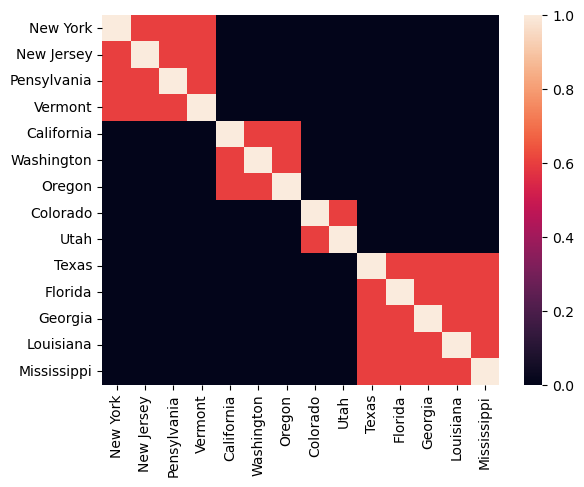

In [7]:
# Time over which to simulate data
time = pd.date_range('2021-01-01', periods=156, freq='W-MON')
# Geographies for which to simulate data
geographies = [
  "New York", "New Jersey", 
  "Pensylvania", "Vermont",
  "California", "Washington",
  "Oregon", "Colorado", 
  "Utah", "Texas",
  "Florida", "Georgia",
  "Louisiana", "Mississippi",
]
# Groupings of geographies
regions = {
  "Northeast": ["New York", "New Jersey", "Pensylvania", "Vermont"],
  "West": ["California", "Washington", "Oregon"],
  "South": ["Texas", "Florida", "Georgia", "Louisiana", "Mississippi"],
  "Mountain": ["Colorado", "Utah"],
}
region_map = {geo: region for region, geos in regions.items() for geo in geos}
# Correlation with region
corr_within = 0.6
corr_between = 0
corr_matrix = np.array([
  [1 if geo1 == geo2 else corr_within if region_map[geo1] == region_map[geo2] else corr_between for geo1 in geographies]
  for geo2 in geographies
])

sns.heatmap(corr_matrix, vmin=0, vmax=1, xticklabels=geographies, yticklabels=geographies)


In [8]:
np.concatenate([np.linspace(i-.2, i+.2, len(regions[key])) for i, key in enumerate(regions.keys())])

array([-0.2       , -0.06666667,  0.06666667,  0.2       ,  0.8       ,
        1.        ,  1.2       ,  1.8       ,  1.9       ,  2.        ,
        2.1       ,  2.2       ,  2.8       ,  3.2       ])

In [9]:
n_gps, n_t = 14, 156
t = np.linspace(0, 156, n_t)
x = np.concatenate([np.linspace(3*i-.5, 3*i+.5, len(regions[key])) for i, key in enumerate(regions.keys())])

eta_true = 1.0
ell_x_true = 1.0
cov_x = eta_true**2 * pm.gp.cov.Matern52(input_dim=1, ls=ell_x_true)
Kx = cov_x(x[:, None])

ell_t_l_true = 52*3
ell_m_l_true = 52
ell_s_l_true = 12
eta_t = 3.0
cov_t_l = eta_t**2 * pm.gp.cov.Matern52(input_dim=1, ls=ell_t_l_true)
cov_t_m = (eta_t/2)**2 * pm.gp.cov.Matern52(input_dim=1, ls=ell_m_l_true)
cov_t_s = (eta_t/4)**2 * pm.gp.cov.Matern52(input_dim=1, ls=ell_s_l_true)
seasonal = pm.gp.cov.Periodic(1, period=52, ls=1) 
cov_t = cov_t_l + cov_t_m + cov_t_s + 3*seasonal
Kt = cov_t(t[:, None])

K = pt.slinalg.kron(Kx, Kt)
f_true = (
    pm.draw(pm.MvNormal.dist(mu=np.zeros(n_gps * n_t), cov=K), random_seed=rng)
    .reshape(n_gps, n_t)
    .T
)

# Additive gaussian noise
sigma_noise = 0.5
noise_dist = pm.Normal.dist(mu=0.0, sigma=sigma_noise)

y_obs = f_true + pm.draw(noise_dist, draws=n_t * n_gps, random_seed=rng).reshape(n_t, n_gps)

In [10]:
geographies_reordered = []
for key in regions.keys():
    geographies_reordered.extend(regions[key])

In [11]:
data = pd.DataFrame(index=time, columns=geographies_reordered, data=y_obs)

In [15]:
mff = (data
  .melt(ignore_index=False)
  .reset_index()
  .rename(
    columns={
      "index": "Period", 
      "variable": "Geography", 
      "value": "VariableValue"
      }
  )
  .assign(Campaign=lambda x: x.Geography.map(region_map))
  .assign(VariableName="sales")
)
mff["Outlet"] = "Test"

In [19]:
mff_columns = set(["Period", "Geography", "Outlet", "Campaign"])
mff_order = ["Period", "Geography", "Outlet", "Campaign"]

In [21]:
columns_to_consider = set(["Outlet"])
group_var = set(['Campaign'])
id_vars = set(["Period", "Geography"])

In [22]:
analytic = mff.pivot(index=[col for col in mff_order if col in id_vars], columns="VariableName" if len((mff_columns - id_vars) - group_var) == 0 else ["VariableName"]+[col for col in mff_order if col in ((mff_columns - id_vars) - group_var)], values="VariableValue" if len(group_var)==0 else ["VariableValue"]+[col for col in mff_order if col in group_var])
analytic.columns = analytic.columns.map(lambda x: "_".join(x))
analytic.reset_index(inplace=True)

In [23]:
analytic.head()

,Period,Geography,VariableValue_sales_Test,Campaign_sales_Test
0,2021-01-04,California,-6.093814,West
1,2021-01-04,Colorado,-0.202638,Mountain
2,2021-01-04,Florida,-7.461876,South
3,2021-01-04,Georgia,-6.449847,South
4,2021-01-04,Louisiana,-4.70838,South


In [24]:
def pipe_wrapper(f):
  def wrapper(*args, **kwargs):
    output = f(*args, **kwargs)
    if isinstance(output, pd.DataFrame):
      return output
    else:
      f(*args, **kwargs)
      if isinstance(args[0], pd.DataFrame):
        return args[0]
  return wrapper

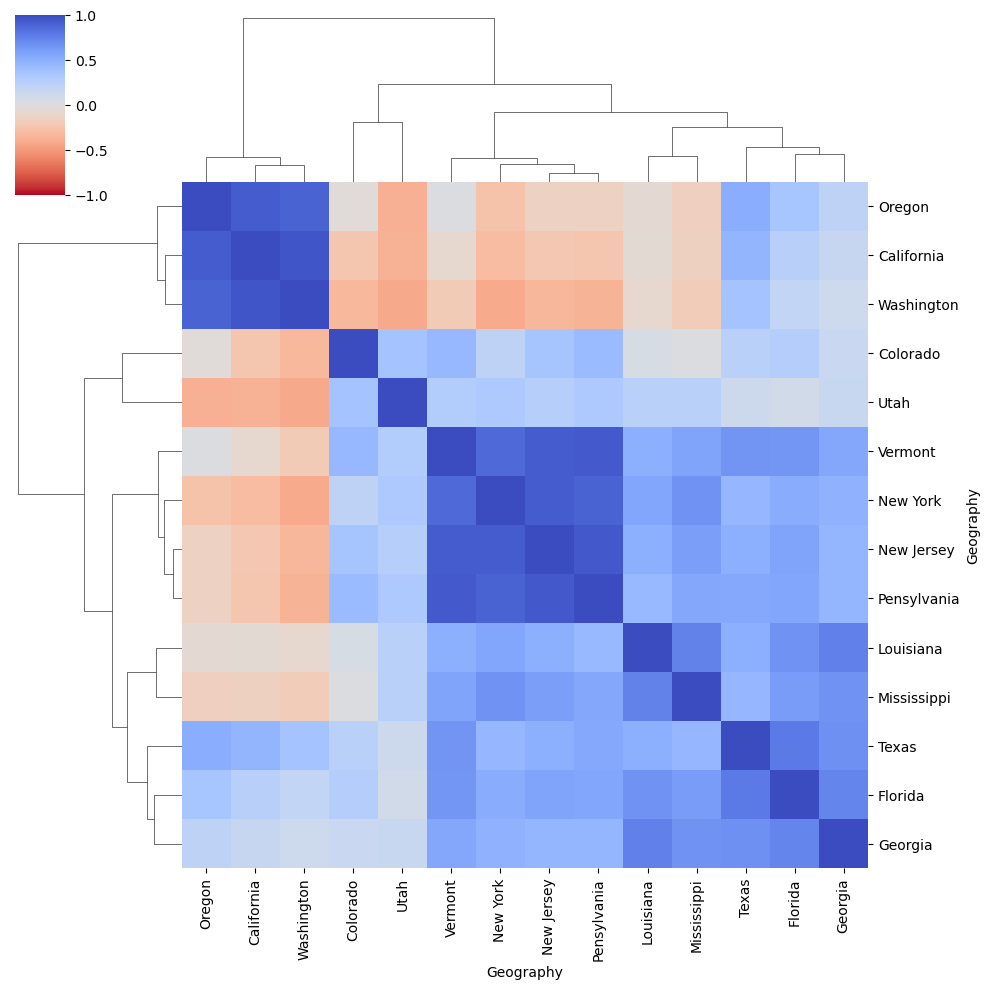

In [26]:
region = "South"
(analytic
  #.query("region_sales==@region")
  .pivot(index="Period", columns='Geography', values="VariableValue_sales_Test")
  .corr()
  .pipe(sns.clustermap, cmap="coolwarm_r", center=0, vmin=-1, vmax=1)
)

In [191]:
%conda install patsy -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/mreda/miniconda3/envs/foottraffic

  added / updated specs:
    - patsy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    patsy-0.5.6                |  py311hca03da5_0         372 KB
    ------------------------------------------------------------
                                           Total:         372 KB

The following NEW packages will be INSTALLED:

  patsy              pkgs/main/osx-arm64::patsy-0.5.6-py311hca03da5_0



patsy-0.5.6          | 372 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kerne

In [192]:
from patsy import dmatrix

In [212]:
splines = dmatrix("bs(x, df=6, degree=3, include_intercept=True) - 1", {"x": np.linspace(0, 1, 156)})
splines = np.asarray(splines, order='F')
spline_dims = np.arange(splines.shape[1])

In [215]:
365/7

52.142857142857146

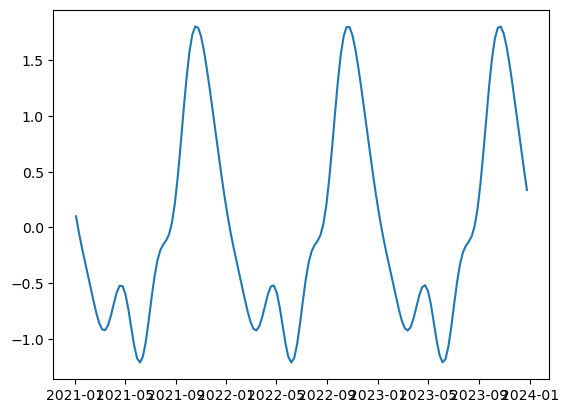

In [229]:
forier_components = np.array(
  [getattr(np, j)(2 * np.pi * i * np.linspace(0, 155, 156)/52.143)/i**1.5 for j in ['cos', 'sin'] for i in range(1, 6)]
)
plt.plot(time, np.random.normal(size=10)@forier_components)

In [231]:
analytic['region_sales'].values.reshape(len(time), len(geographies_reordered))

array([['West', 'Mountain', 'South', ..., 'Mountain', 'Northeast',
        'West'],
       ['West', 'Mountain', 'South', ..., 'Mountain', 'Northeast',
        'West'],
       ['West', 'Mountain', 'South', ..., 'Mountain', 'Northeast',
        'West'],
       ...,
       ['West', 'Mountain', 'South', ..., 'Mountain', 'Northeast',
        'West'],
       ['West', 'Mountain', 'South', ..., 'Mountain', 'Northeast',
        'West'],
       ['West', 'Mountain', 'South', ..., 'Mountain', 'Northeast',
        'West']], dtype=object)

In [240]:
region_factos.astype('float')

array([0., 1., 2., ..., 1., 3., 0.])

In [243]:
analytic['cases_sales'].astype(float).values.reshape(len(time), len(geographies_reordered))

array([[-3.81036596,  4.04307265,  1.23349651, ...,  0.3051001 ,
         4.16087673, -4.61396922],
       [-3.61739425,  4.65489742,  0.5860187 , ...,  1.02304863,
         4.19723139, -5.39646942],
       [-3.3156571 ,  3.97574398,  1.89629538, ...,  0.62990397,
         4.45641446, -4.98279804],
       ...,
       [-0.29095444,  2.09373981, -0.35898168, ..., -1.01539012,
         3.25353508, -2.12203936],
       [ 0.18080109,  2.11797377,  0.81840087, ..., -0.7068413 ,
         2.55024213, -2.96341197],
       [ 0.09146175,  1.40964038, -0.23180084, ..., -1.77189152,
         3.02397184, -2.28296164]])

In [343]:
analytic = analytic.sort_values(["period", "geo"])

In [348]:
region_factos, regions_keys = pd.factorize(analytic['region_sales'])

In [360]:
sorted(geographies)

['California',
 'Colorado',
 'Florida',
 'Georgia',
 'Louisiana',
 'Mississippi',
 'New Jersey',
 'New York',
 'Oregon',
 'Pensylvania',
 'Texas',
 'Utah',
 'Vermont',
 'Washington']

In [430]:
with pm.Model(coords = {
  'geo': sorted(geographies),
  'period': time,
  'region': regions_keys,
  'splines': spline_dims,
  'forier': np.arange(10)
}) as my_model:
  region_data = pm.Data("region_data", region_factos.reshape(len(time), len(geographies_reordered))[0, :], dims=("geo"))
  splines_data = pm.Data("splines_data", splines, dims=("period", "splines"))
  forier_data = pm.Data("forier_data", forier_components.T, dims=("period", "forier"))
  sales = pm.Data('sales', analytic['cases_sales'].astype(float).values.reshape(len(time), len(geographies_reordered)), dims=("period", "geo"))

  trends_betas_mu = pm.Normal("trends_betas_mu", mu=0, sigma=3, dims=("splines",))
  trends_betas_sd = pm.HalfNormal("trends_betas_sd", sigma=3, dims=("splines",))
  trends_betas = pm.Normal("trends_betas", mu=trends_betas_mu, sigma=trends_betas_sd, dims=("region", "splines"))
  trends_betas_geo_sd = pm.HalfNormal("trends_betas_geo_sd", sigma=1, dims=("region"))
  trends_betas_geo = pm.Normal("trends_betas_geos", mu=trends_betas[region_data, :], sigma=trends_betas_geo_sd[region_data, None], dims=("geo", "splines"))
  
  trends = pm.Deterministic('trends', (trends_betas_geo@splines_data.T).T, dims=("period", "geo"))

  forier_betas_mu = pm.Normal("forier_betas_mu", mu=0, sigma=3, dims=("forier",))
  forier_betas_sd = pm.HalfNormal("forier_betas_sd", sigma=3, dims=("forier",))
  forier_betas = pm.Normal("forier_betas", mu=forier_betas_mu, sigma=forier_betas_sd[0], dims=("region", "forier"))
  forier_betas_geo_sd = pm.HalfNormal("forier_betas_geo_sd", sigma=1, dims=("region"))
  forier_betas_geo = pm.Normal("forier_betas_geos", mu=forier_betas[region_data, :], sigma=forier_betas_geo_sd[region_data, None], dims=("geo", "forier"))
  
  season = pm.Deterministic("season", (forier_betas_geo@forier_data.T).T, dims=("period", 'geo'))
  
  intercept_mu = pm.Normal("intercept", 0, 3, dims=('geo'))
  
  mu = pm.Deterministic('mu', season + trends + intercept_mu[None, :], dims=("period", 'geo'))
  
  sigma = pm.HalfNormal("sigma", sigma=3, dims=('geo'))
  cases = pm.Normal("cases", mu=mu, sigma=sigma, observed=sales, dims=("period", 'geo'))
  trace = pm.sample(1000, tune=1000, target_accept=0.99)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [trends_betas_mu, trends_betas_sd, trends_betas, trends_betas_geo_sd, trends_betas_geos, forier_betas_mu, forier_betas_sd, forier_betas, forier_betas_geo_sd, forier_betas_geos, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 218 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'trends_betas_geo_sd'}>,
        <Axes: title={'center': 'trends_betas_geo_sd'}>],
       [<Axes: title={'center': 'trends_betas_sd'}>,
        <Axes: title={'center': 'trends_betas_sd'}>]], dtype=object)

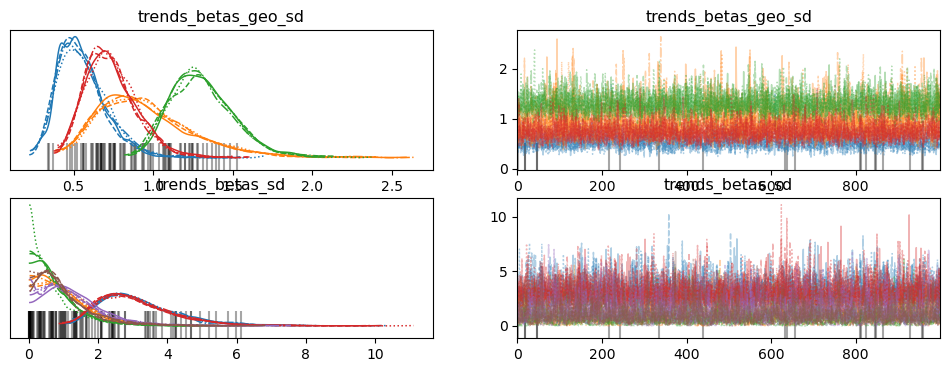

In [431]:
pm.plot_trace(trace, var_names=["trends_betas_geo_sd", "trends_betas_sd"])

In [432]:
%conda install graphviz -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [433]:
pm.model_to_graphviz(my_model)

ImportError: This function requires the python library graphviz, along with binaries. The easiest way to install all of this is by running

	conda install -c conda-forge python-graphviz

In [434]:
trace.observed_data

<xarray.Dataset>
Dimensions:  (period: 156, geo: 14)
Coordinates:
  * period   (period) datetime64[ns] 2021-01-04 2021-01-11 ... 2023-12-25
  * geo      (geo) <U11 'California' 'Colorado' ... 'Vermont' 'Washington'
Data variables:
    cases    (period, geo) float64 -3.81 4.043 1.233 ... -1.772 3.024 -2.283
Attributes:
    created_at:                 2024-09-02T07:46:04.444005
    arviz_version:              0.17.1
    inference_library:          pymc
    inference_library_version:  5.16.1

In [435]:
region_data.eval()

array([0, 1, 2, 2, 2, 2, 3, 3, 0, 3, 2, 1, 3, 0], dtype=int32)

In [436]:
geos_ = analytic['geo'].values.reshape(len(time), len(geographies_reordered))[0, :]


In [438]:
with my_model:
  pm.sample_posterior_predictive(trace, var_names=["cases"], extend_inferencedata=True)

Sampling: [cases]


Output()

In [441]:
trace.posterior_predictive.cases

<xarray.DataArray 'cases' (chain: 4, draw: 1000, period: 156, geo: 14)>
array([[[[-3.77366519e+00,  5.10129597e+00, -4.46929860e-01, ...,
           3.50915811e-01,  4.73742505e+00, -4.93038828e+00],
         [-3.50211210e+00,  4.27922781e+00,  2.53974183e-01, ...,
           6.93042457e-01,  4.30750366e+00, -4.98782538e+00],
         [-3.08072074e+00,  4.44597667e+00,  9.65777844e-01, ...,
           1.45225071e+00,  4.18597661e+00, -5.82869839e+00],
         ...,
         [-8.99622660e-02,  1.20010729e+00, -4.89398572e-01, ...,
          -4.76120261e-01,  3.27496048e+00, -2.52421648e+00],
         [ 6.21458428e-02,  1.82493561e+00, -2.80513410e-01, ...,
          -1.02837447e+00,  3.60939716e+00, -1.88050870e+00],
         [ 4.19937872e-02,  1.43476264e+00,  2.12467546e-01, ...,
          -1.36115420e+00,  2.61815750e+00, -1.61533958e+00]],

        [[-4.69767495e+00,  4.50802732e+00,  1.17249050e+00, ...,
           1.79765703e+00,  5.08857156e+00, -6.16376859e+00],
         [-3.41841375e+00,  3.98554620e+00,  1.32972517e+00, ...,
           9.55453244e-01,  4.34157361e+00, -5.18774023e+00],
         [-3.50954031e+00,  3.50705765e+00,  1.49906949e+00, ...,
           3.48932695e-01,  5.04045683e+00, -5.17863782e+00],
...
         [-6.55967267e-01,  1.04633867e+00, -9.96196263e-01, ...,
          -6.86338392e-01,  2.32645762e+00, -3.05450068e+00],
         [-5.95358691e-02,  1.70692774e+00, -1.26967660e+00, ...,
          -2.01617163e+00,  3.66211131e+00, -1.98145578e+00],
         [-7.07261118e-01,  2.32469958e+00, -2.11624964e-02, ...,
          -6.68363517e-01,  3.02743982e+00, -2.07909980e+00]],

        [[-3.68545855e+00,  4.36582906e+00, -1.02605375e-01, ...,
          -3.13038071e-01,  4.39874816e+00, -4.69887552e+00],
         [-2.98703671e+00,  3.17090088e+00,  8.00775938e-01, ...,
          -1.52989850e-01,  5.44335717e+00, -5.34116209e+00],
         [-4.24352426e+00,  3.82496179e+00,  1.14712464e+00, ...,
           1.69104221e-01,  4.97648870e+00, -5.99764839e+00],
         ...,
         [-4.56588858e-01,  2.15634005e+00,  4.44365896e-01, ...,
          -3.94586298e-01,  3.92793772e+00, -2.74358366e+00],
         [-3.67338326e-01,  1.63020639e+00,  2.08500033e-01, ...,
          -6.28022250e-01,  1.88608497e+00, -2.19922269e+00],
         [-2.64040491e-01,  1.77554517e+00, -1.91065406e-01, ...,
          -1.10470637e+00,  3.39793073e+00, -2.16073017e+00]]]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * period   (period) datetime64[ns] 2021-01-04 2021-01-11 ... 2023-12-25
  * geo      (geo) <U11 'California' 'Colorado' ... 'Vermont' 'Washington'

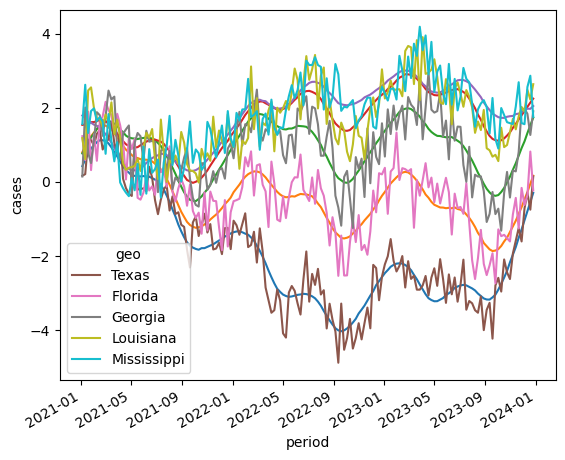

In [443]:
GEO = regions['South']
trace.posterior_predictive["cases"].mean(dim=("chain", "draw")).sel({"geo": GEO}).plot.line(x='period', hue='geo')
trace.observed_data.cases.sel({"geo": GEO}).plot.line(x="period", hue="geo")


In [456]:
hdi = pm.hdi(trace.posterior_predictive.cases, hdi_prob=0.89)
hdi

<xarray.Dataset>
Dimensions:  (period: 156, geo: 14, hdi: 2)
Coordinates:
  * period   (period) datetime64[ns] 2021-01-04 2021-01-11 ... 2023-12-25
  * geo      (geo) <U11 'California' 'Colorado' ... 'Vermont' 'Washington'
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    cases    (period, geo, hdi) float64 -4.913 -3.139 3.045 ... -3.202 -1.348

In [490]:
trace_expanded = trace.posterior.assign(trend_intercept=lambda x: x.intercept + x.trends)

Text(0.5, 0.98, 'Trends')

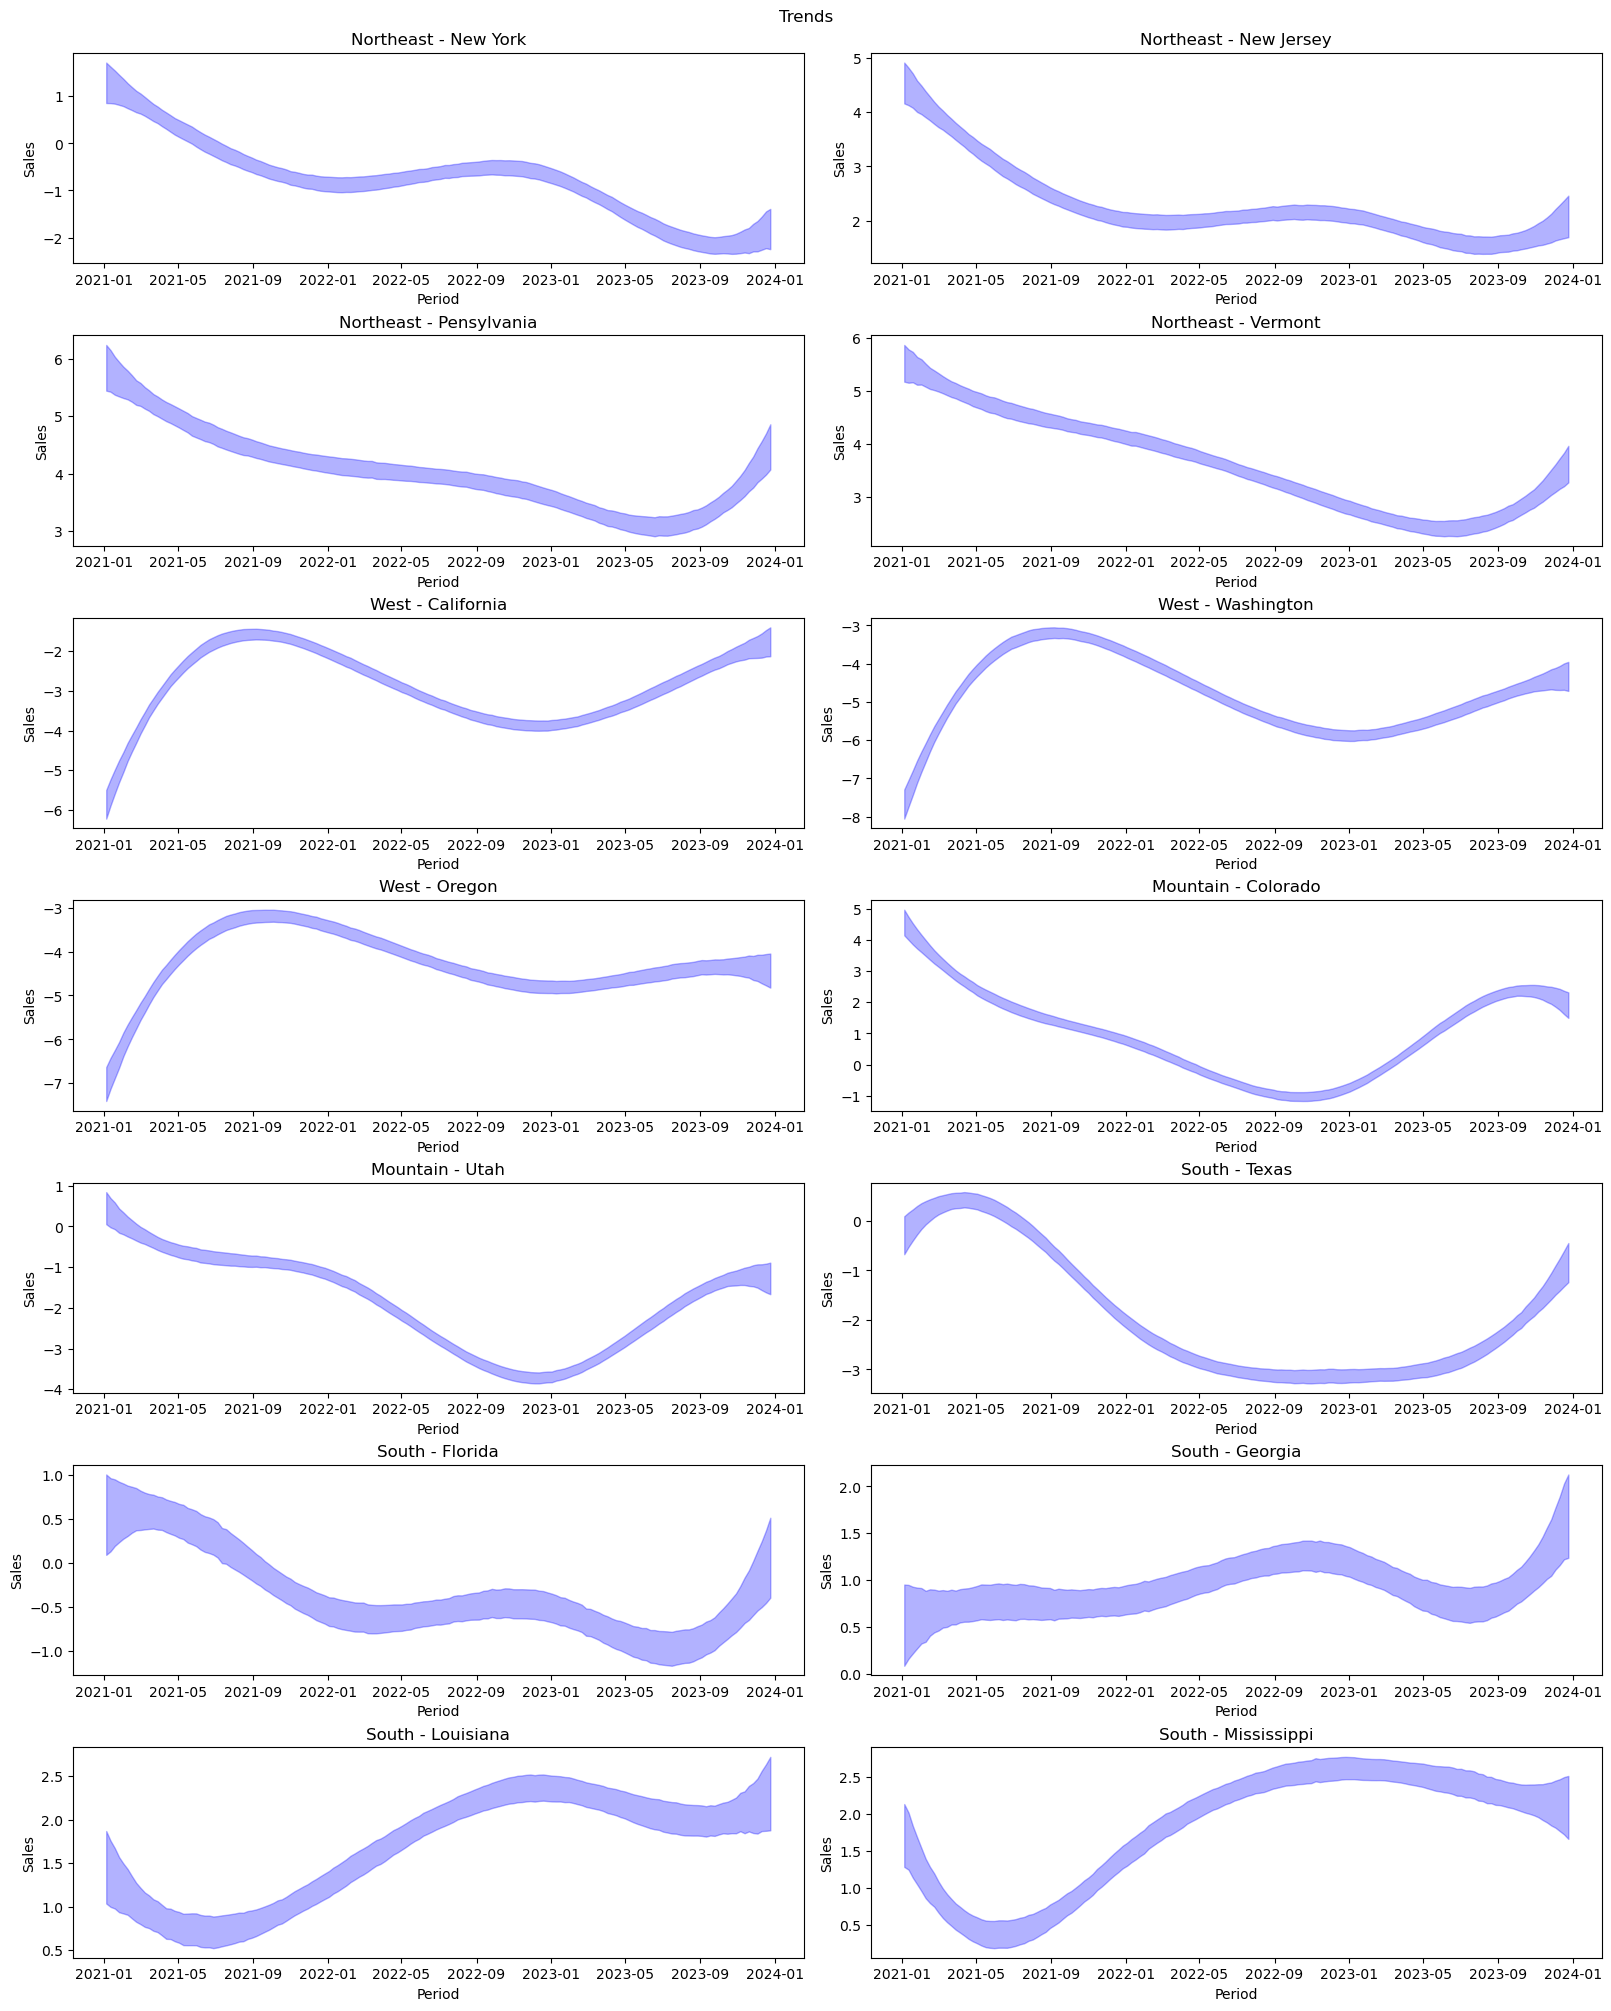

In [492]:
GEO = geographies[10]
fig, ax = plt.subplots(7, 2, figsize=(16, 20), layout="constrained")
hdi = pm.hdi(trace_expanded.trend_intercept, hdi_prob=0.89).trend_intercept
mean_cases = trace.posterior_predictive.cases.mean(dim=("chain", "draw"))
for i, GEO in enumerate(geographies):
  j, i_ = i//2, i%2
  #ax[j, i_].plot(time, mean_cases.sel({"geo": GEO}).values, c='b')
  #ax[j, i_].scatter(time, trace.observed_data.cases.sel({"geo": GEO}).values, c='k')
  ax[j, i_].fill_between(time, hdi.sel({"geo": GEO}).sel({"hdi": "lower"}).values, hdi.sel({"geo": GEO}).sel({"hdi": "higher"}).values, alpha=0.3, color='b')
  ax[j, i_].set_title(f"{region_map[GEO]} - {GEO}")
  ax[j, i_].set_ylabel("Sales")
  ax[j, i_].set_xlabel("Period")
plt.suptitle("Trends")

Text(0.5, 0.98, 'Seasons')

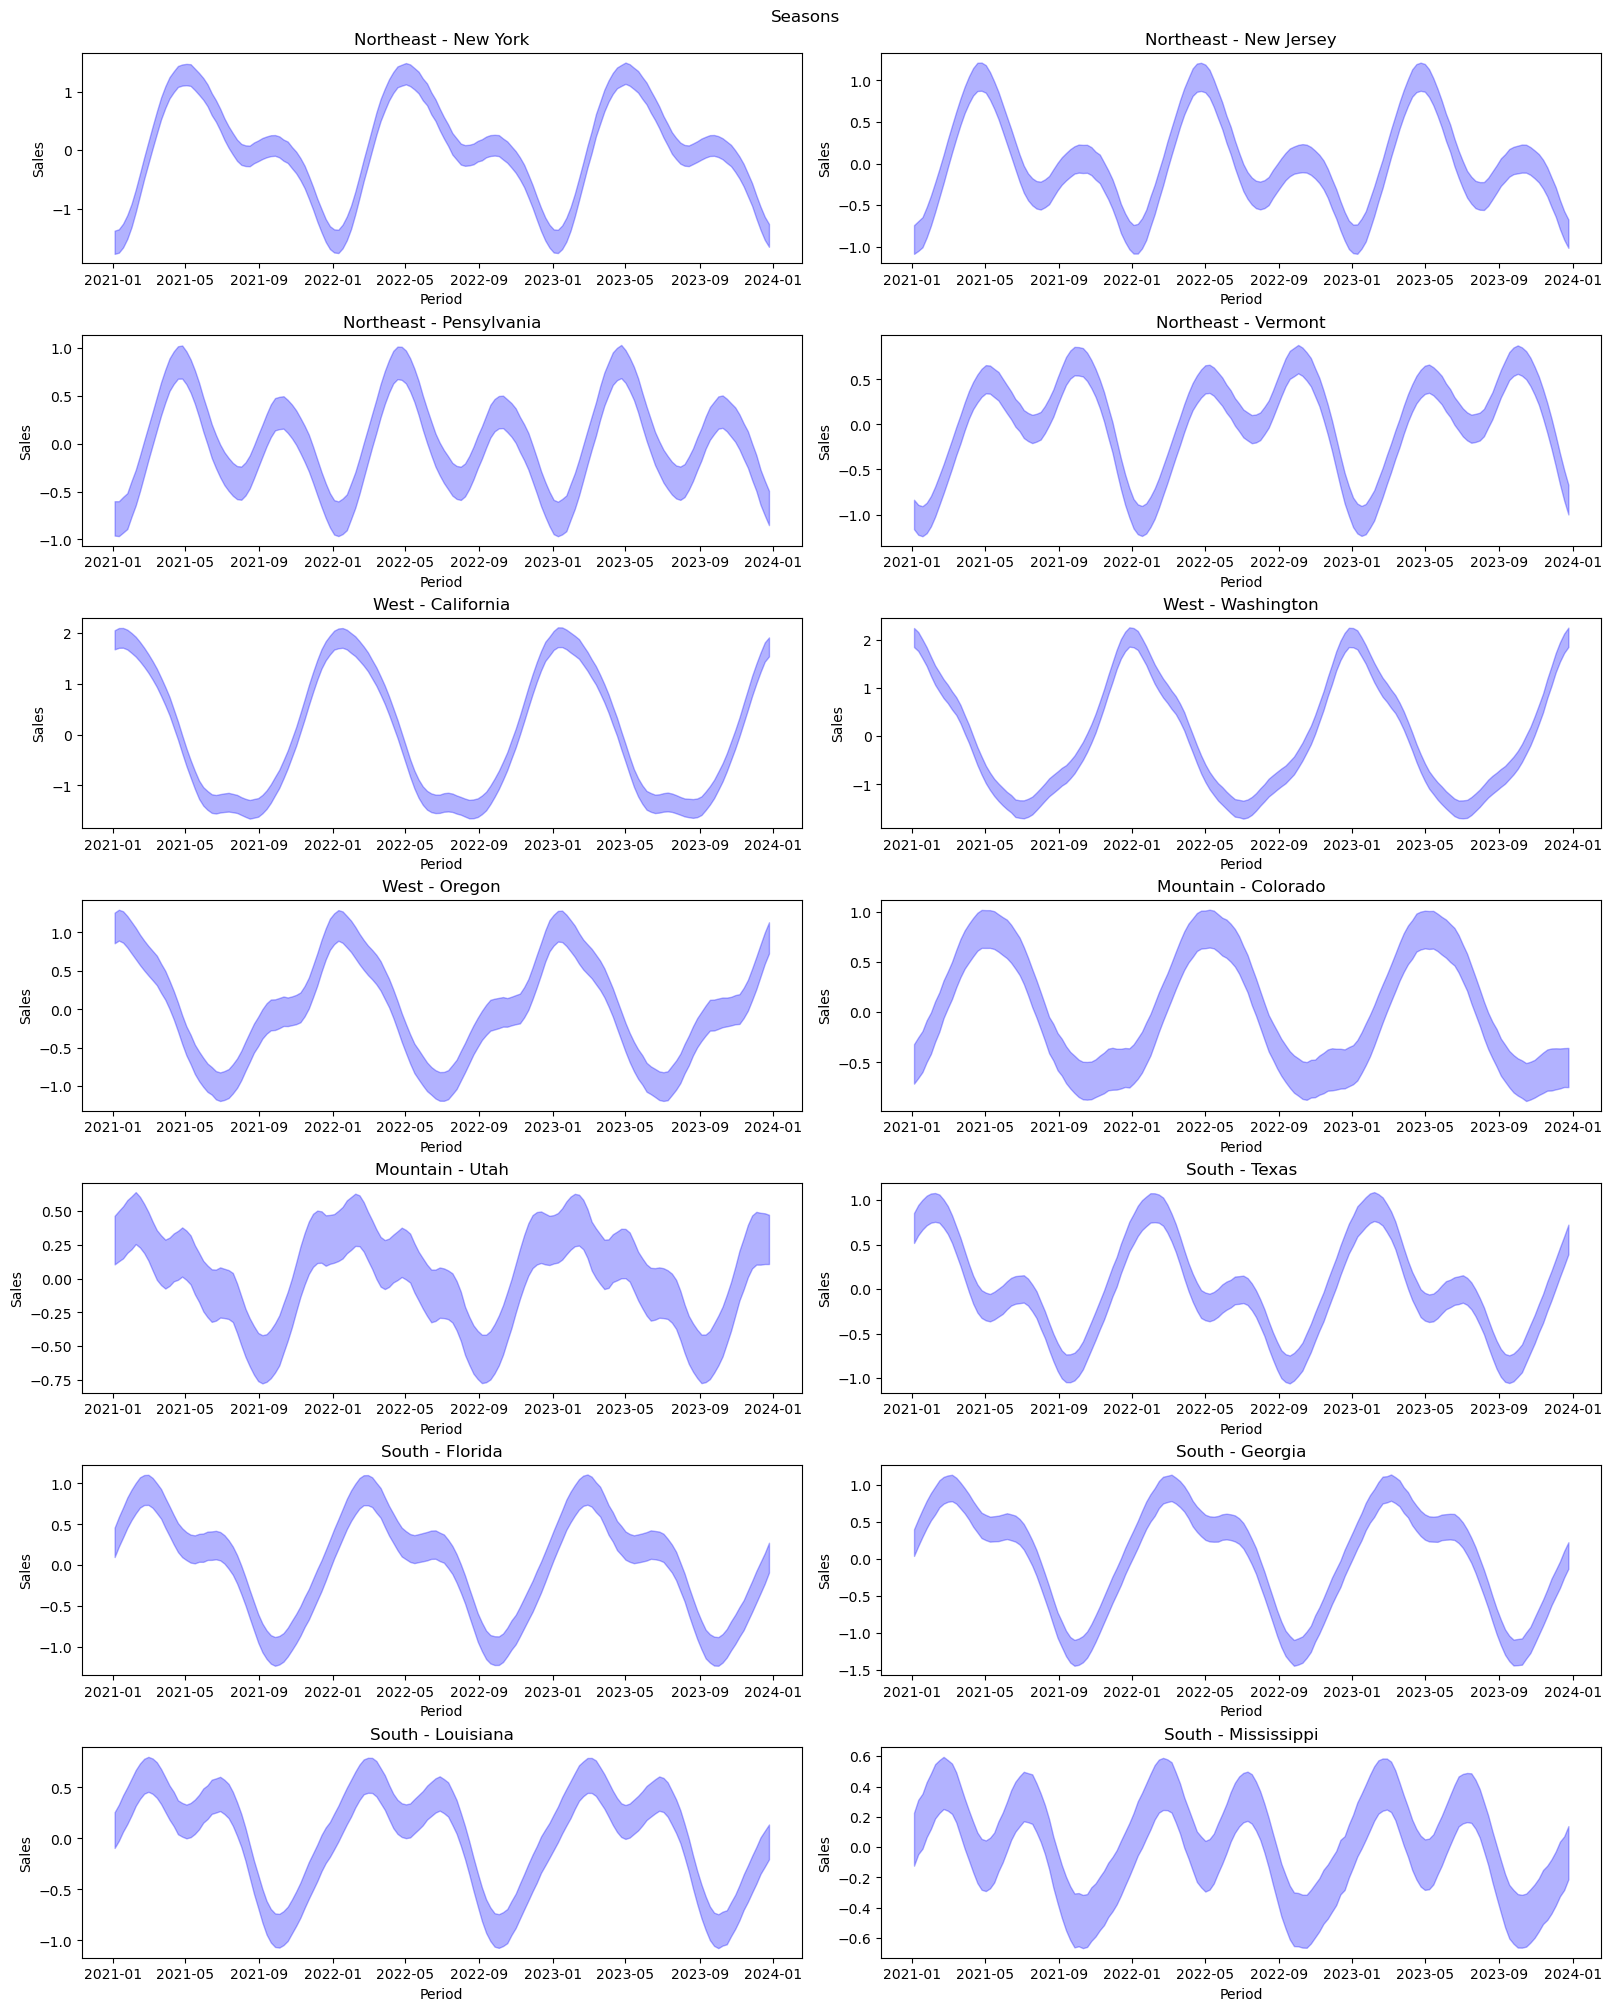

In [493]:
GEO = geographies[10]
fig, ax = plt.subplots(7, 2, figsize=(16, 20), layout="constrained")
hdi = pm.hdi(trace_expanded.season, hdi_prob=0.89).season
mean_cases = trace.posterior_predictive.cases.mean(dim=("chain", "draw"))
for i, GEO in enumerate(geographies):
  j, i_ = i//2, i%2
  #ax[j, i_].plot(time, mean_cases.sel({"geo": GEO}).values, c='b')
  #ax[j, i_].scatter(time, trace.observed_data.cases.sel({"geo": GEO}).values, c='k')
  ax[j, i_].fill_between(time, hdi.sel({"geo": GEO}).sel({"hdi": "lower"}).values, hdi.sel({"geo": GEO}).sel({"hdi": "higher"}).values, alpha=0.3, color='b')
  ax[j, i_].set_title(f"{region_map[GEO]} - {GEO}")
  ax[j, i_].set_ylabel("Sales")
  ax[j, i_].set_xlabel("Period")
plt.suptitle("Seasons")